In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from pprint import pprint

sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [23]:
def set_size(width_pt, fraction=1, subplots=(1, 1), use_golden_ratio=True):
    """
    Reference: https://jwalton.info/Matplotlib-latex-PGF/
    Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    if use_golden_ratio:
        # Golden ratio to set aesthetic figure height
        golden_ratio = (5**0.5 - 1) / 2

        # Figure height in inches
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    else:
        fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# pgf_with_latex = {  # setup matplotlib to use latex for output
#     "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
#     "text.usetex": True,  # use LaTeX to write all text
#     "font.family": "serif",
#     "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
#     "font.sans-serif": [],
#     "font.monospace": [],
#     "axes.labelsize": 10,  # LaTeX default is 10pt font.
#     "font.size": 10,
#     "legend.fontsize": 8,  # Make the legend/label fonts a little smaller
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "pgf.rcfonts": False,  # don't setup fonts from rc parameters
#     "text.latex.preamble": r"\usepackage{amsmath}",
# }

# # But with fonts from the document body
# plt.rcParams.update(pgf_with_latex)

# Using the set_size function as defined earlier
# doc_width_pt = 452.9679

In [3]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [4]:
set_directory_in_project()
data_dir = "./data"
# data_dir = "./smoothed_data"
env_names = [env_name for env_name in os.listdir(data_dir) if not env_name.startswith(".DS_Store")]
print(env_names)

Changed working directory to /home/bryanpu1/projects/adaptive_time
['hopper-v3', 'swimmer-v3', 'pusher-v2', 'cheetah-v3', 'inverted_double_pendulum-v2', 'ant-v3']


In [5]:
# prefixes = ["uniform", "adaptive"]
prefixes = ["uniform-smoothed_data", "adaptive-smoothed_data", "uniform", "adaptive"]
# prefixes = ["uniform-smoothed_data", "adaptive-smoothed_data"]
# prefixes = ["uniform"]

agg_results_per_prefix = {}
samplers_per_prefix = {}
for prefix in prefixes:
    if prefix.startswith("uniform"):
        sampler_constructor = approx_integrators.UniformlySpacedIntegrator
    elif prefix.startswith("adaptive"):
        sampler_constructor = approx_integrators.AdaptiveQuadratureIntegrator
    else:
        raise NotImplementedError
    agg_results_per_prefix[prefix] = pickle.load(open("./{}-combined_mujoco_val_est.pkl".format(prefix), "rb"))
    samplers_per_prefix[prefix] = {
        hyperparam: sampler_constructor(hyperparam) for hyperparam in agg_results_per_prefix[prefix]["ant-v3"]["approx_integrals"]
    }

# Sample trajectories and estimate values

In [6]:
# pprint([(env_name, data["true_value"]) for env_name, data in est_results["adaptive"].items() if env_name not in ["pusher-v2", "inverted_double_pendulum-v2"]])

In [7]:
update_budget = 1_000_000
sample_block = 1_000_000
num_seeds = 10

est_results = {}

for prefix, agg_results in agg_results_per_prefix.items():
    print(prefix)

    agg_prefix = prefix.split("-")[0]
    est_results.setdefault(agg_prefix, {})
    samplers_tried = samplers_per_prefix[prefix]

    print(agg_prefix)
    print(agg_results.keys())

    for env_name in agg_results:
        if not prefix.endswith("-smoothed_data") and env_name not in ["pusher-v2", "inverted_double_pendulum-v2"]:
            continue
        vals_per_state = np.concatenate(
            [np.sum(np.load(reward_file).T, axis=-1) for reward_file in agg_results[env_name]["reward_file"]]
        )
        print([reward_file for reward_file in agg_results[env_name]["reward_file"]])
        print(vals_per_state.shape)

        approx_integrals = agg_results[env_name]["approx_integrals"]
        num_pivots = agg_results[env_name]["num_pivots"]

        weights = np.ones(len(vals_per_state)) / len(vals_per_state)
        true_value = np.sum(weights * vals_per_state)

        est_results[agg_prefix][env_name] = {
            "weights": weights,
            "true_value": true_value,
            "runs": []
        }

        for seed in tqdm(range(num_seeds)):
            estimated_values_by_episode = {}
            number_of_pivots_by_episode = {}
            all_values_by_episode = {}

            rng = np.random.RandomState(seed)
            start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))

            for sampler_name, sampler in samplers_tried.items():
                # print("sampler_name:", sampler_name)
                # Update the value estimate with new samples until we run out of budget.
                used_updates = 0
                value_estimate = 0
                num_episodes = 0
                all_values_by_episode[sampler_name] = []

                estimated_values_by_episode[sampler_name] = []
                number_of_pivots_by_episode[sampler_name] = []

                # pbar = tqdm(total = update_budget)
                while used_updates < update_budget:
                    num_episodes += 1
                    if num_episodes % sample_block == 0:
                        start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))
                    start_state = start_states[(num_episodes - 1) % sample_block]
                    val_sample = approx_integrals[sampler_name][start_state]
                    all_values_by_episode[sampler_name].append(val_sample)
                    
                    value_estimate += (1.0/num_episodes) * (val_sample - value_estimate)
                    used_updates += num_pivots[sampler_name][start_state]

                    estimated_values_by_episode[sampler_name].append(value_estimate)
                    number_of_pivots_by_episode[sampler_name].append(used_updates)
                #     pbar.update(num_pivots[sampler_name][start_state])
                # pbar.close()
            est_results[agg_prefix][env_name]["runs"].append({
                "estimated_values_by_episode": estimated_values_by_episode,
                "number_of_pivots_by_episode": number_of_pivots_by_episode,
                "all_values_by_episode": all_values_by_episode,
            })
        print(est_results[agg_prefix].keys())


uniform-smoothed_data
uniform
dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
['./smoothed_data/swimmer-v3/Rewards_40000_1000_0-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_7-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_6-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_1-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_8-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_9-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_3-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_4-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_5-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_2-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3'])
['./smoothed_data/hopper-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3'])
['./smoothed_data/ant-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3'])
['./smoothed_data/cheetah-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
adaptive-smoothed_data
adaptive
dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
['./smoothed_data/swimmer-v3/Rewards_40000_1000_0-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_7-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_6-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_1-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_8-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_9-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_3-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_4-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_5-smoothed.npy', './smoothed_data/swimmer-v3/Rewards_40000_1000_2-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3'])
['./smoothed_data/hopper-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/hopper-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3'])
['./smoothed_data/ant-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/ant-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3'])
['./smoothed_data/cheetah-v3/Rewards_50000_1000_9-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_8-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_2-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_5-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_4-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_3-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_1-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_6-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_7-smoothed.npy', './smoothed_data/cheetah-v3/Rewards_50000_1000_0-smoothed.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])
uniform
uniform
dict_keys(['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2'])
['./data/inverted_double_pendulum-v2/Rewards_50000_1000_9.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_8.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_6.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_7.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_5.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_4.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_1.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_3.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2'])
['./data/pusher-v2/Rewards_50000_1000_9.npy', './data/pusher-v2/Rewards_50000_1000_8.npy', './data/pusher-v2/Rewards_50000_1000_6.npy', './data/pusher-v2/Rewards_50000_1000_7.npy', './data/pusher-v2/Rewards_50000_1000_5.npy', './data/pusher-v2/Rewards_50000_1000_4.npy', './data/pusher-v2/Rewards_50000_1000_0.npy', './data/pusher-v2/Rewards_50000_1000_1.npy', './data/pusher-v2/Rewards_50000_1000_3.npy', './data/pusher-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2'])
adaptive
adaptive
dict_keys(['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2'])
['./data/inverted_double_pendulum-v2/Rewards_50000_1000_9.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_8.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_6.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_7.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_5.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_4.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_1.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_3.npy', './data/inverted_double_pendulum-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2'])
['./data/pusher-v2/Rewards_50000_1000_9.npy', './data/pusher-v2/Rewards_50000_1000_8.npy', './data/pusher-v2/Rewards_50000_1000_6.npy', './data/pusher-v2/Rewards_50000_1000_7.npy', './data/pusher-v2/Rewards_50000_1000_5.npy', './data/pusher-v2/Rewards_50000_1000_4.npy', './data/pusher-v2/Rewards_50000_1000_0.npy', './data/pusher-v2/Rewards_50000_1000_1.npy', './data/pusher-v2/Rewards_50000_1000_3.npy', './data/pusher-v2/Rewards_50000_1000_2.npy']
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2'])


# Compile plot statistics using interpolation

In [8]:
def process_across_runs(
    runs,
    samplers_tried,
    true_value,
):
    results = {}
    for sampler in samplers_tried:
        interpolated_results = np.zeros((len(runs), update_budget + 1))
        for run_i, run in enumerate(runs):
            number_of_pivots_by_episode = run["number_of_pivots_by_episode"][sampler]
            estimated_values_by_episode = run["estimated_values_by_episode"][sampler]

            interpolated_results[run_i] = np.interp(
                np.arange(update_budget + 1),
                number_of_pivots_by_episode,
                np.abs(estimated_values_by_episode - true_value)[:number_of_pivots_by_episode[-1]]
            )
        results[sampler] = interpolated_results
    return results

In [9]:
print(est_results["adaptive"].keys(), est_results["uniform"].keys())

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2']) dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'inverted_double_pendulum-v2', 'pusher-v2'])


In [10]:
print(est_results.keys())

dict_keys(['uniform', 'adaptive'])


In [11]:

plot_stats = {}
for prefix, curr_result in est_results.items():
    print(prefix)
    # samplers_tried = samplers_per_prefix["{}-smoothed_data".format(prefix)]
    samplers_tried = samplers_per_prefix[prefix]
    plot_stats[prefix] = {}
    for env_i, env_name in enumerate(tqdm(curr_result)):
        true_value = curr_result[env_name]["true_value"]
        env_result = process_across_runs(
            curr_result[env_name]["runs"],
            samplers_tried,
            true_value
        )
        plot_stats[prefix][env_name] = env_result

uniform


  0%|          | 0/6 [00:00<?, ?it/s]

adaptive


  0%|          | 0/6 [00:00<?, ?it/s]

# Plot error vs number of updates

## Plot aggregated result

In [12]:
# s_to_plot = ["q1", "q10", "q100", "u1", "u10", "u500"]
# s_to_plot = ["q0", "u1"]
# s_to_plot = samplers_tried.keys()
plot_this = False
if plot_this:
    ncols = 3
    fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

    start_idx = 0
    end_idx = 1_000_000
    for env_i, env_name in enumerate(env_names):
        ax = axes[env_i // ncols, env_i % ncols]
        for prefix in prefixes:
            env_result = plot_stats[prefix][env_name]
            samplers_tried = samplers_per_prefix[prefix]
            for s in tqdm(samplers_tried):
                y_means = np.nanmean(env_result[s][:, start_idx:end_idx], axis=0)
                y_stderrs = np.nanstd(env_result[s][:, start_idx:end_idx], axis=0) / np.sqrt(num_seeds)
                x_range = np.arange(update_budget + 1)[start_idx:end_idx]

                y_means = np.log10(y_means, out=np.zeros_like(y_means), where=(y_means != 0))
                y_stderrs = np.log10(y_stderrs, out=np.zeros_like(y_stderrs), where=(y_stderrs != 0))

                ax.plot(
                    x_range,
                    y_means,
                    label=s if env_i == 0 else ""
                )
                ax.fill_between(
                    x_range,
                    (y_means - y_stderrs),
                    (y_means + y_stderrs),
                    alpha=0.1
                )
        ax.set_title("Env: {}".format(env_name))

    fig.supylabel("Error in value estimate")
    fig.supxlabel("Number of Samples")
    fig.legend()
    plt.show()

# Plot error vs hyperparameter (i.e. tolerance/discretization)

In [13]:
budgets_to_check_per_env = {
    "inverted_double_pendulum-v2": (25000, np.array([1, 2, 5, 10, 20, 40])),
    "swimmer-v3": (20000, np.array([1, 2, 5, 10, 20, 40])),
    "hopper-v3": (8000, np.array([1, 2, 5, 10, 20, 40])),
    "ant-v3": (25000, np.array([1, 2, 5, 10, 20, 40])),
    "cheetah-v3": (25000, np.array([1, 2, 5, 10, 20, 40])),
    "pusher-v2": (25000, np.array([1, 2, 5, 10, 20, 40])),
}

# Approximate horizon for adaptive method for "same mapping"

In [14]:
print(agg_results.keys())

dict_keys(['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2'])


In [15]:
print(agg_results_per_prefix.keys())

dict_keys(['uniform-smoothed_data', 'adaptive-smoothed_data', 'uniform', 'adaptive'])


In [16]:
print(plot_stats.keys())

dict_keys(['uniform', 'adaptive'])


In [17]:
print(plot_stats.keys())

dict_keys(['uniform', 'adaptive'])


In [18]:
agg_results_per_prefix["adaptive-smoothed_data"]

{'swimmer-v3': {'approx_integrals': {'q0.125': array([14250.430638  , 14236.78441803, 14070.65320628, ...,
          14073.29302359, 14132.96908702, 14047.63316929]),
   'q0.1767766952966369': array([14250.42895485, 14236.78065231, 14070.65086888, ...,
          14073.29565234, 14132.96435555, 14047.63126017]),
   'q0.25': array([14250.43175985, 14236.78182428, 14070.64382678, ...,
          14073.28849374, 14132.96542245, 14047.62653659]),
   'q0.3535533905932738': array([14250.43792977, 14236.78051399, 14070.64018499, ...,
          14073.27844702, 14132.95988255, 14047.62118625]),
   'q0.5': array([14250.43465348, 14236.78384763, 14070.64518603, ...,
          14073.27932291, 14132.97135776, 14047.61423902]),
   'q0.7071067811865476': array([14250.43129453, 14236.76617434, 14070.64003539, ...,
          14073.28483142, 14132.9555161 , 14047.61252524]),
   'q1.0': array([14250.43622506, 14236.78286575, 14070.60170481, ...,
          14073.2347752 , 14132.9532638 , 14047.58681237]),
 

In [19]:
adaptive_prefix = "adaptive-smoothed_data"

tolerances = np.power(10, np.arange(-2.0, 4.0, 1.0)) * 5
samplers_tried = {
    "q{}".format(tolerance): approx_integrators.AdaptiveQuadratureIntegrator(tolerance=tolerance) for tolerance in tolerances
}

tau_to_h = {}
for env_i, env_name in enumerate(env_names):
    traj_len = 40000 if env_name == "swimmer-v3" else 50000
    prefix = adaptive_prefix.split("-")[0] if env_name in ["pusher-v2", "inverted_double_pendulum-v2"] else adaptive_prefix
    print(prefix, adaptive_prefix, env_name)
    env_result = plot_stats[adaptive_prefix.split("-")[0]][env_name]
    num_pivots = agg_results_per_prefix[prefix][env_name]["num_pivots"]
    tau_to_h[env_name] = np.array([
        (sampler, math.ceil(np.mean(traj_len / (num_pivots[sampler] - 1)))) for sampler in num_pivots
    ])

adaptive-smoothed_data adaptive-smoothed_data hopper-v3
adaptive-smoothed_data adaptive-smoothed_data swimmer-v3
adaptive adaptive-smoothed_data pusher-v2
adaptive-smoothed_data adaptive-smoothed_data cheetah-v3
adaptive adaptive-smoothed_data inverted_double_pendulum-v2
adaptive-smoothed_data adaptive-smoothed_data ant-v3


In [20]:
map_env = {
    
}

hopper-v3
8000
[['q0.125' '41']
 ['q0.1767766952966369' '46']
 ['q0.25' '56']
 ['q0.3535533905932738' '65']
 ['q0.5' '81']
 ['q0.7071067811865476' '92']
 ['q1.0' '110']
 ['q1.4142135623730951' '128']
 ['q2.0' '160']
 ['q2.8284271247461903' '180']
 ['q4.0' '223']
 ['q5.656854249492381' '260']
 ['q8.0' '322']
 ['q11.313708498984761' '361']
 ['q16.0' '435']
 ['q22.627416997969522' '509']
 ['q32.0' '655']
 ['q45.254833995939045' '733']
 ['q64.0' '904']
 ['q90.50966799187809' '1063']
 ['q128.0' '1331']
 ['q181.01933598375618' '1506']
 ['q256.0' '2084']
 ['q362.03867196751236' '2500']
 ['q512.0' '3402']
 ['q1024.0' '3572']
 ['q724.0773439350247' '3572']
 ['q1448.1546878700494' '4165']
 ['q2048.0' '4167']
 ['q2896.309375740099' '4167']
 ['q4096.0' '7774']]


  0%|          | 0/6 [00:00<?, ?it/s]

8000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

swimmer-v3
20000
[['q0.125' '53']
 ['q0.1767766952966369' '63']
 ['q0.25' '74']
 ['q0.3535533905932738' '88']
 ['q0.5' '105']
 ['q0.7071067811865476' '125']
 ['q1.0' '148']
 ['q1.4142135623730951' '176']
 ['q2.0' '212']
 ['q2.8284271247461903' '253']
 ['q4.0' '300']
 ['q5.656854249492381' '357']
 ['q8.0' '429']
 ['q11.313708498984761' '510']
 ['q16.0' '606']
 ['q22.627416997969522' '723']
 ['q32.0' '871']
 ['q45.254833995939045' '1036']
 ['q64.0' '1231']
 ['q90.50966799187809' '1482']
 ['q128.0' '1705']
 ['q181.01933598375618' '2011']
 ['q256.0' '2332']
 ['q362.03867196751236' '2612']
 ['q512.0' '3001']
 ['q724.0773439350247' '3643']
 ['q1024.0' '3923']
 ['q1448.1546878700494' '4719']
 ['q2048.0' '7981']
 ['q2896.309375740099' '15200']
 ['q4096.0' '19923']]


  0%|          | 0/6 [00:00<?, ?it/s]

20000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

pusher-v2
25000
[['q0.125' '46']
 ['q0.1767766952966369' '53']
 ['q0.25' '61']
 ['q0.3535533905932738' '72']
 ['q0.5' '83']
 ['q0.7071067811865476' '98']
 ['q1.0' '116']
 ['q1.4142135623730951' '137']
 ['q2.0' '162']
 ['q2.8284271247461903' '193']
 ['q4.0' '232']
 ['q5.656854249492381' '277']
 ['q8.0' '330']
 ['q11.313708498984761' '395']
 ['q16.0' '474']
 ['q22.627416997969522' '569']
 ['q32.0' '673']
 ['q45.254833995939045' '800']
 ['q64.0' '951']
 ['q90.50966799187809' '1119']
 ['q128.0' '1298']
 ['q181.01933598375618' '1545']
 ['q256.0' '1794']
 ['q362.03867196751236' '2037']
 ['q512.0' '2313']
 ['q724.0773439350247' '2824']
 ['q1024.0' '3394']
 ['q1448.1546878700494' '3868']
 ['q2048.0' '4102']
 ['q2896.309375740099' '4194']
 ['q4096.0' '4510']]


  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

cheetah-v3
25000
[['q0.125' '16']
 ['q0.1767766952966369' '18']
 ['q0.25' '22']
 ['q0.3535533905932738' '26']
 ['q0.5' '31']
 ['q0.7071067811865476' '36']
 ['q1.0' '43']
 ['q1.4142135623730951' '52']
 ['q2.0' '62']
 ['q2.8284271247461903' '72']
 ['q4.0' '85']
 ['q5.656854249492381' '104']
 ['q8.0' '124']
 ['q11.313708498984761' '143']
 ['q16.0' '170']
 ['q22.627416997969522' '209']
 ['q32.0' '249']
 ['q45.254833995939045' '288']
 ['q64.0' '339']
 ['q90.50966799187809' '417']
 ['q128.0' '496']
 ['q181.01933598375618' '570']
 ['q256.0' '678']
 ['q362.03867196751236' '844']
 ['q512.0' '986']
 ['q724.0773439350247' '1155']
 ['q1024.0' '1309']
 ['q1448.1546878700494' '1597']
 ['q2048.0' '1983']
 ['q2896.309375740099' '2216']
 ['q4096.0' '2725']]


  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

inverted_double_pendulum-v2
25000
[['q0.125' '241']
 ['q0.1767766952966369' '296']
 ['q0.25' '375']
 ['q0.3535533905932738' '477']
 ['q0.5' '597']
 ['q0.7071067811865476' '749']
 ['q1.0' '948']
 ['q1.4142135623730951' '1186']
 ['q2.0' '1545']
 ['q2.8284271247461903' '1986']
 ['q4.0' '2572']
 ['q5.656854249492381' '3276']
 ['q8.0' '4310']
 ['q11.313708498984761' '5481']
 ['q16.0' '7042']
 ['q22.627416997969522' '9106']
 ['q32.0' '11915']
 ['q45.254833995939045' '14750']
 ['q64.0' '17520']
 ['q90.50966799187809' '20022']
 ['q128.0' '22140']
 ['q181.01933598375618' '23780']
 ['q256.0' '24833']
 ['q362.03867196751236' '25000']
 ['q2048.0' '25000']
 ['q4096.0' '25000']
 ['q1024.0' '25000']
 ['q512.0' '25000']
 ['q1448.1546878700494' '25000']
 ['q724.0773439350247' '25000']
 ['q2896.309375740099' '25000']]


  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

ant-v3
25000
[['q0.125' '25']
 ['q0.1767766952966369' '30']
 ['q0.25' '35']
 ['q0.3535533905932738' '44']
 ['q0.5' '52']
 ['q0.7071067811865476' '61']
 ['q1.0' '72']
 ['q1.4142135623730951' '88']
 ['q2.0' '104']
 ['q2.8284271247461903' '122']
 ['q4.0' '144']
 ['q5.656854249492381' '173']
 ['q8.0' '205']
 ['q11.313708498984761' '242']
 ['q16.0' '286']
 ['q22.627416997969522' '339']
 ['q32.0' '404']
 ['q45.254833995939045' '487']
 ['q64.0' '581']
 ['q90.50966799187809' '694']
 ['q128.0' '840']
 ['q181.01933598375618' '998']
 ['q256.0' '1196']
 ['q362.03867196751236' '1451']
 ['q512.0' '1748']
 ['q724.0773439350247' '2103']
 ['q1024.0' '2534']
 ['q1448.1546878700494' '3087']
 ['q2048.0' '3722']
 ['q2896.309375740099' '4431']
 ['q4096.0' '5158']]


  0%|          | 0/6 [00:00<?, ?it/s]

25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/6 [00:00<?, ?it/s]

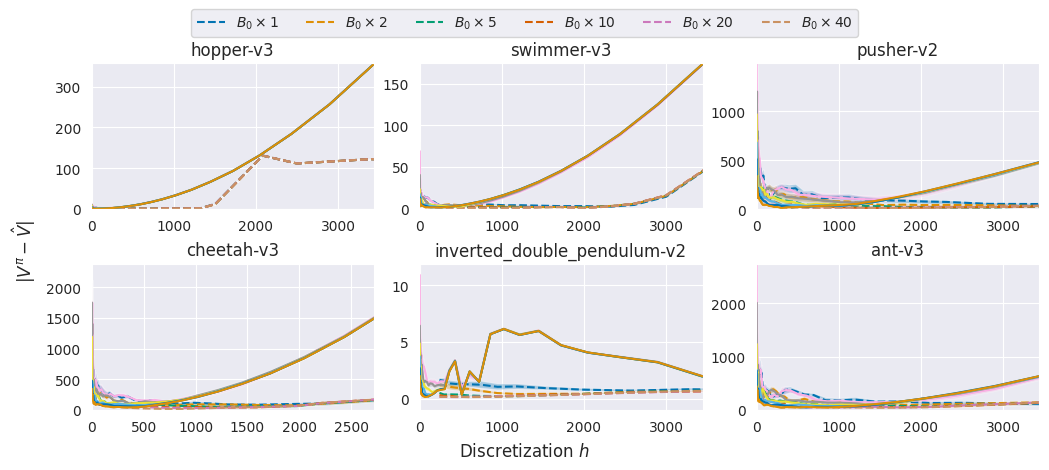

In [37]:
doc_width_pt = 750.0
ncols = 3
nrows = len(env_names) // ncols
# fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=set_size(doc_width_pt, 1.0, (nrows, ncols)), layout="constrained")

for env_i, env_name in enumerate(env_names):
    print(env_name)
    min_spacing = np.inf
    max_err = 0.0
    for sampler_type_i, prefix in enumerate(["adaptive", "uniform"]):
    # for prefix in ["adaptive"]:
        if prefix.startswith("uniform"):
            spacing_keys = np.array(list(samplers_per_prefix[prefix].keys()))
            # spacing_keys = np.array(list(samplers_per_prefix["{}-smoothed_data".format(prefix)].keys()))
            spacing = np.array([int(key[1:]) for key in spacing_keys])
            sorted_idxes = np.argsort(spacing)
            sorted_spacing = spacing[sorted_idxes]
            sorted_keys = ["u{}".format(item) for item in sorted_spacing]
        elif prefix.startswith("adaptive"):
            sorted_idxes = np.argsort(tau_to_h[env_name][:, 1].astype(int))
            sorted_spacing = tau_to_h[env_name][:, 1][sorted_idxes].astype(int)
            sorted_keys = tau_to_h[env_name][:, 0][sorted_idxes]
        else:
            raise NotImplementedError

        env_result = plot_stats[prefix][env_name]
        ax = axes[env_i // ncols, env_i % ncols]

        base_budget, multipliers = budgets_to_check_per_env[env_name]
        print(base_budget)
        print(np.vstack((sorted_keys, sorted_spacing)).T)
        if sorted_spacing[-1] < min_spacing:
            min_spacing = sorted_spacing[-1]

        for multiplier in tqdm(multipliers):
            idx = int(base_budget * multiplier)
            y_means = []
            y_stderrs = []
            for s in sorted_keys:
                y_means.append(np.nanmean(env_result[s][:, idx]))
                y_stderrs.append(np.nanstd(env_result[s][:, idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            ax.plot(
                sorted_spacing,
                y_means,
                label="$B_0 \\times {}$".format(multiplier) if env_i == 0 and sampler_type_i == 0 else "",
                linestyle="-" if prefix.startswith("uniform") else "--"
            )
            ax.fill_between(
                sorted_spacing,
                (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.3
            )

            if prefix.startswith("uniform") and max_err < np.max(y_means):
                max_err = np.max(y_means)
        ax.set_title("{}".format(env_name))
        ax.set_xlim(-10, min_spacing)
        ax.set_ylim(-1, max_err + 1)

fig.supylabel("$| V^\\pi - \\hat{V} |$")
fig.supxlabel("Discretization $h$")

fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=6,
    borderaxespad=0.0,
    frameon=True,
    fontsize="10",
)
# plt.show()
plt.savefig("agg_res.pdf", dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
# data = np.load("./data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy")
# data = np.load("./data/ant-v3/Rewards_50000_1000_0.npy")
# data = np.load("./data/hopper-v3/Rewards_50000_1000_0.npy")
# data = np.load("./data/cheetah-v3/Rewards_50000_1000_0.npy")
# data = np.load("./data/pusher-v2/Rewards_50000_1000_0.npy")
data = np.load("./data/swimmer-v3/Rewards_40000_1000_0.npy")

In [ ]:
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
x_range = np.arange(data.shape[1])
plt.plot(x_range, mean)
# plt.fill_between(x_range, mean - std, mean + std, alpha=0.1)
# plt.ylim(9.358, 9.362)
plt.show()
print(np.mean(np.sum(data, axis=1)))

In [ ]:
agg_results_per_prefix["adaptive"]["swimmer-v3"]["num_pivots"]

In [ ]:
agg_results_per_prefix["adaptive"]["swimmer-v3"]["reward_file"]

In [ ]:
data = np.load("./{}/ant-v3/Rewards_50000_1000_8-smoothed.npy".format(data_dir))

In [ ]:
ncols = 4
fig, axes = plt.subplots(nrows=5, ncols=ncols, figsize=(25, 15), layout="constrained")

for traj_i in range(20):
    ax = axes[traj_i // ncols, traj_i % ncols]
    ax.plot(data.T[traj_i])
plt.show()

In [ ]:
np.sum(data.T[0])